## Exploring the differences between a skip-gram and a continuous bag of words model in relation to the Game of Thrones text
In this notebook I will explore the difference in a continuous bag of words (CBOW) and a skip-gram model. The data I will be exploring is the text of all 5 Game of Thrones books. I found this data from the link https://www.kaggle.com/muhammedfathi/game-of-thrones-book-files/code.

I should note that while I have not read these books, I have watched every episode of the HBO Game of Thrones series and throughout this assignment I tried to do as much research to find the differences between the text and show so that I do not make false assumptions between the story line and the way it is written. Some of my analysis is dependent on the syntactical context of how characters are referred to or how some characters speak. I tried to do my best to understand which characters are referred to in certain ways but I cant promise that the context from which I analyze this is perfect.



In [1]:
from time import time 
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 

warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [130]:
# data downloaded from https://www.kaggle.com/muhammedfathi/game-of-thrones-book-files/code
book1 = open("----file location for got1.txt---",encoding="utf8") 
s1 = book1.read() 
book2 = open("----file location for got2.txt---",encoding="utf8") 
s2 = book2.read() 
book3 = open("----file location for got3.txt---",encoding="utf8") 
s3 = book3.read() 
book4 = open("----file location for got4.txt---",encoding="utf8") 
s4 = book4.read() 
book5 = open("----file location for got5.txt---",encoding="utf8") 
s5 = book5.read() 
s = s1+s2+s3+s4+s5
j = s.replace("\n", " ") 
data = [] 
wordcount = {}

j = j.replace(",","")
j = j.replace(":","")
j = j.replace("","")
j = j.replace('“',"")
j = j.replace('’',"")
j = j.replace('“',"")
j = j.replace('”',"")
j = j.replace("!","")
j = j.replace("?","")
j = j.replace(";","")
j = j.replace(",","")
j = j.replace("â€œ","")
j = j.replace("â€˜","")
j = j.replace("-","")

# iterate through each sentence in the file 
for i in sent_tokenize(j): 
    temp = [] 

    # tokenize the sentence into words 
    for ind,j in enumerate(word_tokenize(i)): 
        j = j.lower() 
        if(j != "" and j != "."):
            if j not in wordcount:
                wordcount[j] = 1
            else:
                wordcount[j] += 1
            temp.append(j)
    data.append(temp)

## Some data exploration to see if my parsing/cleaning data was effective
I wanted to keep track of the number of words in the dataset so I could refer back to them later. To make sure my method of cleaning the data was effective I wanted to see the most common words to make sure everything but the letters were thrown out.

How many most common words to print: 30

The 30 most common words are as follows

the :  104524
and :  52428
a :  40639
to :  40134
of :  37892
he :  27826
his :  26538
was :  22096
you :  19329
her :  19184
i :  19063
in :  18157
had :  17039
it :  16401
that :  15906
as :  15171
she :  14853
with :  13313
him :  12500
not :  12285
but :  11299
for :  10962
is :  9207
they :  9010
on :  8996
at :  8854
said :  8749
my :  8617
have :  8596
be :  8070


<AxesSubplot:xlabel='Word'>

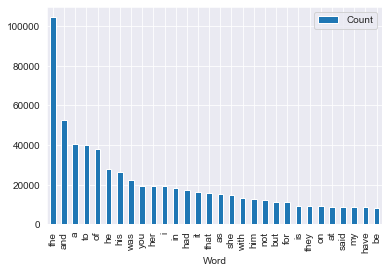

In [131]:
n_print = int(input("How many most common words to print: "))
print("\nThe {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
# print(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

#create plot
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

## Initialize/Train Models
Using the gensim library with the word2vec embeddings and parameters equal to those used in https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [134]:
w2v_CBOW = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
w2v_SG = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     sg = 1,
                     negative=20)

I used the idea I found in https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial to time how long it took to build the vocab and train for the skip-gram and CBOW models

In [135]:
t = time()

w2v_SG.build_vocab(data, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [136]:
t = time()

w2v_CBOW.build_vocab(data, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [137]:
t = time()

w2v_SG.train(data, total_examples=w2v_SG.corpus_count, epochs=30)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.4 mins


In [138]:
t = time()

w2v_CBOW.train(data, total_examples=w2v_CBOW.corpus_count, epochs=30)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.73 mins


On my machine, the training for the skip-gram model took about twice as long as the training for the CBOW model. The difference here is to be expected because we know the CBOW model is usually several times faster than the skip-gram model.

In [140]:
#Make model more memory efficient
w2v_CBOW.init_sims(replace=True)
w2v_SG.init_sims(replace=True)

## Analyzing model
Now that the model is trained, it is time to see what it an do!

In Game of Thrones, there is a constant battle for the thrones, as the name suggests. Many different characters claim to be king or queen of certain land and territory. Because of this, I am very interested to see what relationships the model claims to be between words "king"/"queen" and the multitude of characters that assume these roles throughout the arc of the story. 

In [141]:
w2v_CBOW.wv.most_similar("king", topn=20)

[('ii', 0.5394653677940369),
 ('rightful', 0.5054821968078613),
 ('baratheon', 0.5028559565544128),
 ('rebel', 0.49412035942077637),
 ('robert', 0.47612956166267395),
 ('traitor', 0.47539034485816956),
 ('grandson', 0.4702787697315216),
 ('usurper', 0.47010594606399536),
 ('jaehaerys', 0.46397897601127625),
 ('rebellion', 0.46223005652427673),
 ('cleon', 0.46095746755599976),
 ('targaryens', 0.45676282048225403),
 ('beloved', 0.44750896096229553),
 ('regent', 0.44512006640434265),
 ('daeron', 0.4438960552215576),
 ('renly', 0.4435766339302063),
 ('lawful', 0.4434812068939209),
 ('joffrey', 0.4355320930480957),
 ('stannis', 0.43338051438331604),
 ('trueborn', 0.4129958152770996)]

In [142]:
w2v_SG.wv.most_similar("king", topn=20)

[('ii', 0.4935241937637329),
 ('queen', 0.4867549538612366),
 ('stannis', 0.4344838261604309),
 ('father', 0.4286800026893616),
 ('grandson', 0.42263472080230713),
 ('he', 0.42135295271873474),
 ('lawful', 0.4212566018104553),
 ('joffrey', 0.41398748755455017),
 ('the', 0.4112287759780884),
 ('jaehaerys', 0.4110495448112488),
 ('rebel', 0.4105033278465271),
 ('rightful', 0.4102800786495209),
 ('regent', 0.4101627767086029),
 ('cersei', 0.40856239199638367),
 ('cleon', 0.40281951427459717),
 ('homage', 0.4013349115848541),
 ('son', 0.3998880386352539),
 ('declare', 0.3994368314743042),
 ('brother', 0.399265855550766),
 ('kings', 0.39889001846313477)]

After running the two cells above, there is not an aparent difference in the type of words that the two models claim to be similar to "king" so more analysis is needed.

A useful side note: The word "ii" refers the meaning of "junior" as in "King Aerys II"

## Count for most common words by model
Perhaps if I looked at the counts for the top 20 similar words to "king" in each model I could find a meaningful insight

In [145]:
#CBOW model
sum = 0
for i in [j for j in w2v_CBOW.wv.most_similar("king", topn=20)]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for ii : 30
Count for rightful : 69
Count for baratheon : 359
Count for rebel : 23
Count for robert : 928
Count for traitor : 100
Count for grandson : 27
Count for usurper : 62
Count for jaehaerys : 28
Count for rebellion : 75
Count for cleon : 46
Count for targaryens : 48
Count for beloved : 42
Count for regent : 53
Count for daeron : 28
Count for renly : 456
Count for lawful : 24
Count for joffrey : 729
Count for stannis : 1132
Count for trueborn : 60
Total sum of words above: 4319


In [148]:
#skip-gram model
sum = 0
for i in [j for j in w2v_SG.wv.most_similar("king", topn=20)]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for ii : 30
Count for queen : 1646
Count for stannis : 1132
Count for father : 2157
Count for grandson : 27
Count for he : 27826
Count for lawful : 24
Count for joffrey : 729
Count for the : 104524
Count for jaehaerys : 28
Count for rebel : 23
Count for rightful : 69
Count for regent : 53
Count for cersei : 1133
Count for cleon : 46
Count for homage : 27
Count for son : 1682
Count for declare : 22
Count for brother : 1734
Count for kings : 1623
Total sum of words above: 144535


While the count will very as you change the number of epochs, one pattern I found throughout is that the total sum of the number of words is usually far greater for the skip gram model because of the inclusion of words such as "he" and "the". Since these are words with incredibly high frequencies of occurance, the count will obviously be higher for the skip-gram model.

## Finding similarity between paired words
In the following section I will further explore the way in which these two models relate words through the use of the cosine-similarity distance.

In [149]:

d = {"word1":[],"word2":[],"word_relationship":[]}
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")
d["word_relationship"].append("name to king")

d["word_relationship"].append("name to queen")
d["word_relationship"].append("name to queen")

#pairing characters with king or queen
d["word1"].append("renly")
d["word1"].append("ned")
d["word1"].append("robert")
d["word1"].append("jon")
d["word1"].append("tommen")
d["word1"].append("stannis")
d["word1"].append("balon")
d["word1"].append("viserys")
d["word1"].append("joffrey")
d["word1"].append("aerys")

d["word1"].append("cersei")
d["word1"].append("dany")

d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")
d["word2"].append("king")

d["word2"].append("queen")
d["word2"].append("queen")


d = pd.DataFrame(data = d)

sg_score = []
cbow_score = []
for ind in range(0,len(d)):
    sg_score.append(w2v_SG.similarity(d["word1"][ind],d["word2"][ind]))
    cbow_score.append(w2v_CBOW.similarity(d["word1"][ind],d["word2"][ind]))
d["CBOW_score"] = cbow_score
d["SG_score"] = sg_score

d

,word1,word2,word_relationship,CBOW_score,SG_score
0,renly,king,name to king,0.443577,0.306462
1,ned,king,name to king,0.212573,0.293069
2,robert,king,name to king,0.476130,0.389440
3,jon,king,name to king,0.048377,0.231653
4,tommen,king,name to king,0.351196,0.314991
5,stannis,king,name to king,0.433380,0.434484
6,balon,king,name to king,0.204712,0.316766
7,viserys,king,name to king,0.204398,0.245253
8,joffrey,king,name to king,0.435532,0.413987
9,aerys,king,name to king,0.406478,0.245778


The table above shows the relationship between 12 characters who claimed to be, and were regarded as a king or queen at one point in time throughout the arc of the story. I pair these characters with the word "king" or "queen" and calculate the pair's cosine similarity score for each model.

This output was honestly dissapointing in my mind. I was hoping to be able to see a clear difference in the cosine similarity score between the two models but it is fairly hard to discern any significant difference between the two models.


In [150]:
d = {"word1":[],"word2":[],"word_relationship":[]}

d["word1"].append("king")
d["word1"].append("queen")
d["word1"].append("lord")
d["word1"].append("lady")
d["word1"].append("traitor")
d["word1"].append("dragon")
d["word1"].append("ser")
d["word1"].append("sword")

#Often the word "protector" is used in the context of "Protector of the realm" or "protector of the land"
d["word2"].append("protector")
d["word2"].append("protector")
d["word2"].append("protector")
d["word2"].append("protector")
d["word2"].append("usurper")
d["word2"].append("beast")
d["word2"].append("knight")
d["word2"].append("weapon")


d["word_relationship"].append("similar meaning")
d["word_relationship"].append("similar meaning")

d["word_relationship"].append("similar meaning")
d["word_relationship"].append("similar meaning")

d["word_relationship"].append("similar meaning")
d["word_relationship"].append("similar meaning")
d["word_relationship"].append("similar meaning")
d["word_relationship"].append("similar meaning")




d = pd.DataFrame(data = d)

sg_score = []
cbow_score = []
for ind in range(0,len(d)):
    sg_score.append(w2v_SG.similarity(d["word1"][ind],d["word2"][ind]))
    cbow_score.append(w2v_CBOW.similarity(d["word1"][ind],d["word2"][ind]))
d["CBOW_score"] = cbow_score
d["SG_score"] = sg_score

d

,word1,word2,word_relationship,CBOW_score,SG_score
0,king,protector,similar meaning,0.361959,0.291655
1,queen,protector,similar meaning,0.320874,0.276222
2,lord,protector,similar meaning,0.295690,0.317160
3,lady,protector,similar meaning,0.244024,0.287869
4,traitor,usurper,similar meaning,0.407236,0.323294
5,dragon,beast,similar meaning,0.143353,0.177825
6,ser,knight,similar meaning,0.303647,0.431570
7,sword,weapon,similar meaning,0.337069,0.304125


This table is designed to test the semantic ability of each model. However, it appears that there is not a significant difference in the two models relative scores for each pair of words. Perhaps my tests are not the best examples of semantically similar pairs.

In [169]:
d = {"word1":[],"word2":[],"word_relationship":[]}

d["word1"].append("the")
d["word1"].append("the")
d["word1"].append("the")
d["word1"].append("nights")
d["word1"].append("father")
d["word1"].append("castle")
d["word1"].append("she")
d["word1"].append("very")

d["word2"].append("king")
d["word2"].append("queen")
d["word2"].append("north")
d["word2"].append("watch")
d["word2"].append("said")
d["word2"].append("black")
d["word2"].append("slipped")
d["word2"].append("careful")

d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")
d["word_relationship"].append("neighboring")

d = pd.DataFrame(data = d)

sg_score = []
cbow_score = []
for ind in range(0,len(d)):
    sg_score.append(w2v_SG.similarity(d["word1"][ind],d["word2"][ind]))
    cbow_score.append(w2v_CBOW.similarity(d["word1"][ind],d["word2"][ind]))
d["CBOW_score"] = cbow_score
d["SG_score"] = sg_score

d

,word1,word2,word_relationship,CBOW_score,SG_score
0,the,king,neighboring,0.037782,0.411229
1,the,queen,neighboring,-0.053011,0.314689
2,the,north,neighboring,0.229588,0.331491
3,nights,watch,neighboring,0.433855,0.575117
4,father,said,neighboring,0.138596,0.354438
5,castle,black,neighboring,0.105444,0.243576
6,she,slipped,neighboring,-0.002204,0.121547
7,very,careful,neighboring,0.147424,0.128404


Now it finally appears that there is a noticable difference in the cosine scores of the two models. As we can see, the skip-gram model is much better at recognizing words that are often neighboring each other which the CBOW model is very bad at this.

In [170]:
d = {"word1":[],"word2":[],"word_relationship":[]}

d["word1"].append("jon")
d["word1"].append("tommen")
d["word1"].append("joffrey")
d["word1"].append("bran")
d["word1"].append("tyrion")
d["word1"].append("dany")

d["word2"].append("ned")
d["word2"].append("robert")
d["word2"].append("robert")
d["word2"].append("ned")
d["word2"].append("tywin")
d["word2"].append("aegon")

d["word_relationship"].append("child to parent")
d["word_relationship"].append("child to parent")
d["word_relationship"].append("child to parent")
d["word_relationship"].append("child to parent")
d["word_relationship"].append("child to parent")
d["word_relationship"].append("child to parent")

d = pd.DataFrame(data = d)

sg_score = []
cbow_score = []
for ind in range(0,len(d)):
    sg_score.append(w2v_SG.similarity(d["word1"][ind],d["word2"][ind]))
    cbow_score.append(w2v_CBOW.similarity(d["word1"][ind],d["word2"][ind]))
d["CBOW_score"] = cbow_score
d["SG_score"] = sg_score

d

,word1,word2,word_relationship,CBOW_score,SG_score
0,jon,ned,child to parent,0.382781,0.397230
1,tommen,robert,child to parent,0.431220,0.290297
2,joffrey,robert,child to parent,0.528063,0.338488
3,bran,ned,child to parent,0.305260,0.358559
4,tyrion,tywin,child to parent,0.306590,0.371980
5,dany,aegon,child to parent,0.015833,0.169024


In this table I explore the scores for pairs of words of a child and a parent. I was honestly not expecting much from this test but I was surprised that the scores were as high as they are. I suppose that there are often sentences where a child and a parent are referenced together or talking with each other so I expect this inflated the score.

In [157]:
d = {"word1":[],"word2":[],"word_relationship":[]}

d["word1"].append("jon")
d["word1"].append("tommen")
d["word1"].append("joffrey")
d["word1"].append("bran")
d["word1"].append("tyrion")
d["word1"].append("dany")

d["word2"].append("snow")
d["word2"].append("baratheon")
d["word2"].append("baratheon")
d["word2"].append("stark")
d["word2"].append("lannister")
d["word2"].append("targaryen")

d["word_relationship"].append("first to last name")
d["word_relationship"].append("first to last name")
d["word_relationship"].append("first to last name")
d["word_relationship"].append("first to last name")
d["word_relationship"].append("first to last name")
d["word_relationship"].append("first to last name")

d = pd.DataFrame(data = d)

sg_score = []
cbow_score = []
for ind in range(0,len(d)):
    sg_score.append(w2v_SG.similarity(d["word1"][ind],d["word2"][ind]))
    cbow_score.append(w2v_CBOW.similarity(d["word1"][ind],d["word2"][ind]))
d["CBOW_score"] = cbow_score
d["SG_score"] = sg_score

d

,word1,word2,word_relationship,CBOW_score,SG_score
0,jon,snow,first to last name,0.376058,0.517674
1,tommen,baratheon,first to last name,0.303414,0.291781
2,joffrey,baratheon,first to last name,0.303289,0.339293
3,bran,stark,first to last name,0.258739,0.305504
4,tyrion,lannister,first to last name,0.207107,0.337168
5,dany,targaryen,first to last name,0.176088,0.235125


Again, I see a significant difference in the two models cosine scores. The skip gram model gives higher cosine similarity scores to the first to last name than the CBOW model does. As I mentioned before, this suggests that skip-gram is better at recognizing neighboring ideas because the text would often refer to characters as "Jon Snow" or "Bran Stark" etc.

## T-SNE visualization

In [112]:
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

I then wanted to look at some better visualizations of the data to help me learn more about how well the models are working. I found a function from the site https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial that creates a nice t-SNE visualization. T-SNE scales quadractically with the number of objects inputted so since my dataset was relatively small, I figured I could perform this fairly quickly. 

In [183]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn = 20)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 30,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(10)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

First I will look at the top 20 words most similar to "king" plotted with the top 20 which are least similar. The green words are those which are most unsimilar from "king" while the blue are those most similar.

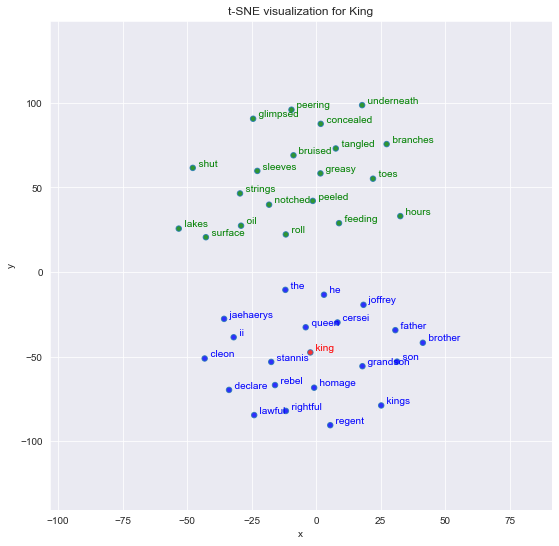

In [184]:
tsnescatterplot(w2v_SG, 'king',[i[0] for i in w2v_SG.wv.most_similar(negative=["king"], topn = 20)])

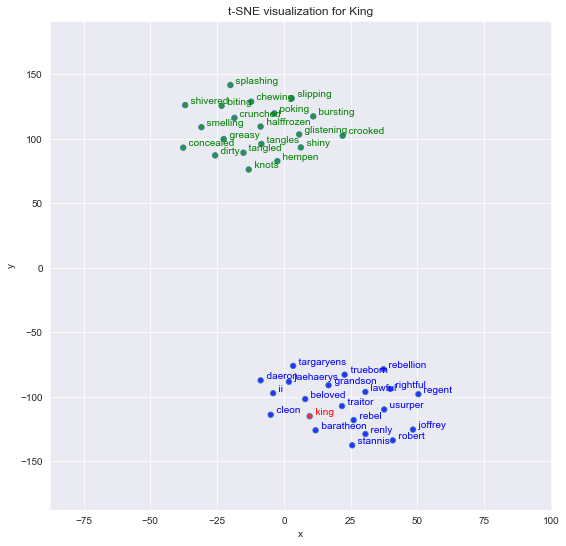

In [185]:
tsnescatterplot(w2v_CBOW, 'king',[i[0] for i in w2v_CBOW.wv.most_similar(negative=["king"],topn = 20)])

While these plots clearly show the two clumps vary drastically from each other, it was again difficult to differentiate between the two models. I was happy to see how unrelated the words in the green clumps were from "king" though.

I was also curious to see if there would be an effect of the frequency of the words in the above plot. It seemed fairly obvious that names of kings such as "Joffrey", "Robert", and "Daeron" as well as common words such as "Queen" and "Rebellion" would occur with a higher frequency than words such as "Lip" or "Bark" so I wanted to explore this idea.

In [187]:
#counts for words similar with "king" for skip-gram
sum = 0
for i in [j for j in w2v_SG.wv.most_similar(positive=["king"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for ii : 30
Count for queen : 1646
Count for stannis : 1132
Count for father : 2157
Count for grandson : 27
Count for he : 27826
Count for lawful : 24
Count for joffrey : 729
Count for the : 104524
Count for jaehaerys : 28
Total sum of words above: 138123


In [189]:
#counts for words not similar with "king" for skip-gram
sum = 0
for i in [j for j in w2v_SG.wv.most_similar(negative=["king"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for greasy : 34
Count for glimpsed : 114
Count for toes : 84
Count for peering : 38
Count for branches : 127
Count for roll : 46
Count for sleeves : 47
Count for strings : 30
Count for hours : 147
Count for shut : 133
Total sum of words above: 800


In [190]:
#counts for words similar with "king" for CBOW
sum = 0
for i in [j for j in w2v_CBOW.wv.most_similar(positive=["king"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for ii : 30
Count for rightful : 69
Count for baratheon : 359
Count for rebel : 23
Count for robert : 928
Count for traitor : 100
Count for grandson : 27
Count for usurper : 62
Count for jaehaerys : 28
Count for rebellion : 75
Total sum of words above: 1701


In [191]:
#counts for words not similar with "king" for CBOW
sum = 0
for i in [j for j in w2v_CBOW.wv.most_similar(negative=["king"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for concealed : 30
Count for dirty : 47
Count for tangled : 72
Count for splashing : 30
Count for greasy : 34
Count for chewing : 32
Count for glistening : 29
Count for smelling : 20
Count for slipping : 33
Count for knots : 20
Total sum of words above: 347


As I had suspected the frequency of words most similar with "king" is far greater than those least similar with "king" for both the skip-gram and the CBOW models. The obvious question is then "how much does the model attribute similarity due to the frequency of the word pairs?". This is a question that I am not sure I can answer quantitatively with the tools at my disposal. However, from a qualitivative standpoint, it makes sense that since "king" is used so much, the words most similar to it would likely be used frequently as well. To see if the relationship holds for words used infrequently, I will look at words most similar to some of those that are very unsimilar to "king"

In [192]:
#counts for words similar with "boot" for skip-gram
sum = 0
for i in [j for j in w2v_SG.wv.most_similar(positive=["boot"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for toe : 35
Count for kegs : 24
Count for ribs : 59
Count for jack : 36
Count for forearm : 27
Count for dirk : 91
Count for shirt : 41
Count for string : 31
Count for mully : 41
Count for halfhelm : 25
Total sum of words above: 410


In [194]:
#counts for words least similar with "boot" for skip-gram
sum = 0
for i in [j for j in w2v_SG.wv.most_similar(negative=["boot"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for perished : 37
Count for betrayed : 77
Count for wears : 29
Count for crowned : 111
Count for undying : 31
Count for occupied : 26
Count for galare : 27
Count for galazza : 23
Count for raising : 41
Count for greatest : 36
Total sum of words above: 438


In [195]:
#counts for words similar with "boot" for CBOW
sum = 0
for i in [j for j in w2v_CBOW.wv.most_similar(positive=["boot"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for toe : 35
Count for ribs : 59
Count for kegs : 24
Count for forearm : 27
Count for heel : 66
Count for gloves : 81
Count for jerkin : 55
Count for glove : 53
Count for mully : 41
Count for nails : 43
Total sum of words above: 484


In [196]:
#counts for words least similar with "boot" for CBOW
sum = 0
for i in [j for j in w2v_CBOW.wv.most_similar(negative=["boot"])]:
    print("Count for",i[0],":", word_counter[i[0]])
    sum+=word_counter[i[0]]
print("Total sum of words above:",sum)

Count for greatest : 36
Count for restore : 39
Count for qarth : 126
Count for —their : 48
Count for —her : 48
Count for returns : 42
Count for stormborn : 30
Count for oppose : 22
Count for peril : 28
Count for sacked : 26
Total sum of words above: 445


There is not a ton of analysis I can add to the above 4 cells. It seems to be pretty clear that the frequency of the words most similar to "boot" is about the same as those least similar to "boot" according to each model. My idea that there might be a relationship between the positive similarity and frequency of words seems to be wrong. It does appear that the models have correctly identified words similar and not similar to boot though when looking at this list. The words most similar are often either body parts, or clothes to put on these body parts. The words least similar are pretty random and do appear to have no relationship to "boot".

## Final thoughts
This was a very interesting exploration of the data and the differences between the skip-gram model and the CBOW model. It seems to me that the two models did in fact work pretty well in identifying words that are similar to other words as well as ones that are not similar at all. In addition, the models were able to give relatively high cosine similarity scores for the variety of word pairs I provided each model. I was a little dissapointed in this area to not see as much of a difference between the two models scores because as we learned in class, the CBOW model is generally better at syntactic classification while the skip-gram is better at semantic classification. I was reluctanct to mention this in my above analysis of the word pairs because it did not appear that I could accurately, with no bias, state that the models differed in their semantic/syntactic analysis. 

Perhaps my tests were poor examples to show the models differences, perhaps the dataset was too small in order to significantly realize theses similarities, or perhaps in my training I did not do enough epochs to properly train the data. If I were to do furhter analysis I would like to find a much larger data set and be able to run many more epochs when training the models before analyzing the data and performance of the models.